In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datasets as ds

/home/jhoffbauer/reddit_qa/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ELIF_COMMENTS = "/scratch1/jhoff/explainlikeimfive_comments.jsonl"
ELIF_SUBMISSIONS = "/scratch1/jhoff/explainlikeimfive_submissions.jsonl"

In [3]:
print('number of lines')
print(f'  comments: {len(open(ELIF_COMMENTS).readlines())}')
print(f'  submissions  {len(open(ELIF_SUBMISSIONS).readlines())}')

number of lines
  comments: 16258308
  submissions  1803202


In [4]:
# Let's work on the submissions first
df_elif_submissions = pd.read_json(ELIF_SUBMISSIONS, lines=True)
print(f"Size after load: {round(df_elif_submissions.memory_usage(deep=True).sum() / (1024**3), 3)}GB")

# Delete a few columns we wont need
submission_cols_to_delete = [
    'author', 'author_flair_css_class', 'clicked', 'distinguished', 'domain', 'gilded', 
    'link_flair_css_class', 'media_embed', 'secure_media', 'secure_media_embed', 
    'selftext_html', 'stickied', 'subreddit_id', 'thumbnail', 'saved', 'url', 'edited',
    'link_flair_text', 'report_reasons', 'author_flair_text', 'banned_by', 'mod_reports',
    'permalink', 'approved_by', 'user_reports', 'media', 'hidden', 'created', 'likes', 'num_reports',
    'subreddit'
]
for col in submission_cols_to_delete:
    if col in df_elif_submissions.columns:
        del df_elif_submissions[col]

# Convert dates
df_elif_submissions['created_utc'] = pd.to_datetime(df_elif_submissions['created_utc'], unit='s')
df_elif_submissions['retrieved_on'] = pd.to_datetime(df_elif_submissions['retrieved_on'], unit='s')

# Mark deleted submissions
df_elif_submissions['deleted'] = df_elif_submissions['selftext'].apply(lambda x: '[deleted]' in x or '[removed]' in x)

df_elif_submissions.head(5)

Size after load: 5.241GB


,downs,id,created_utc,name,title,is_self,selftext,num_comments,ups,score,...,treatment_tags,upvote_ratio,is_created_from_ads_ui,retrieved_utc,top_awarded_type,call_to_action,crosspost_parent,crosspost_parent_list,url_overridden_by_dest,deleted
0,4.0,j2pag,2011-07-28 23:56:50,t3_j2pag,Can someone explain to me what a tax bracket is?,True,I hear the term all the time in money speak bu...,14,25.0,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,0.0,j2p9d,2011-07-28 23:55:39,t3_j2p9d,Can someone explain to me how to rate an Orche...,True,I have recently went to a live local orchestra...,0,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,2.0,j2p92,2011-07-28 23:55:18,t3_j2p92,[LI5] Can you please explain to me what exactl...,True,,2,23.0,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,8.0,j2p84,2011-07-28 23:54:22,t3_j2p84,World War 2. Explain like I'm 5.,True,"Who what where and most importantly, why?",12,27.0,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,0.0,j2p7y,2011-07-28 23:54:11,t3_j2p7y,Why is my reflexion upside down when I look in...,True,,0,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [5]:
for col in ['deleted', 'is_self', 'over_18']:
    # Print value counts with indent
    print(df_elif_submissions[col].value_counts(normalize=True).apply(lambda x: f"{round(x * 100, 4)}%").to_string().replace('\n', '\n  '))

deleted
  True     50.7838%
  False    49.2162%
is_self
  True     99.9913%
  False     0.0087%
over_18
  False    99.6251%
  True      0.3749%


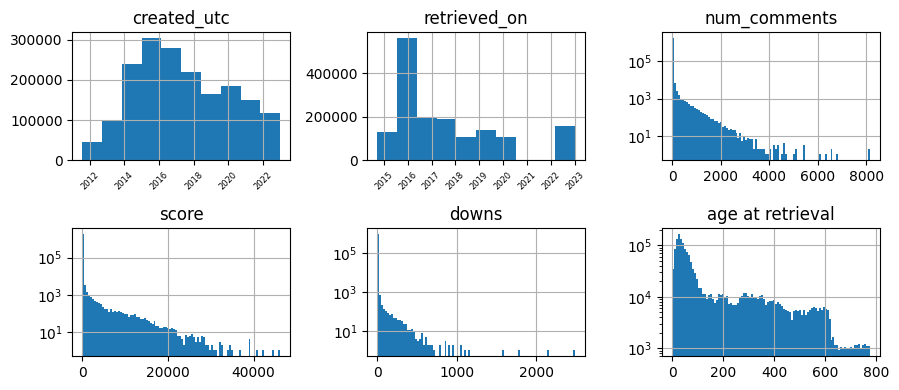

In [6]:
figsize=(9, 4)

fig, axes = plt.subplots(nrows=2, ncols=3)

axes[0, 0].set_title('created_utc')
df_elif_submissions.created_utc.hist(ax=axes[0, 0], xrot=45, figsize=figsize, xlabelsize=6)

axes[0, 1].set_title('retrieved_on')
df_elif_submissions.retrieved_on.hist(ax=axes[0, 1], xrot=45, figsize=figsize, xlabelsize=6)

axes[0, 2].set_title('num_comments')
df_elif_submissions.num_comments.hist(ax=axes[0, 2], bins=100, log=True, figsize=figsize)

axes[1, 0].set_title('score')
df_elif_submissions.score.hist(ax=axes[1, 0], bins=100, log=True, figsize=figsize)

axes[1, 1].set_title('downs')
df_elif_submissions.downs.hist(ax=axes[1, 1], bins=100, log=True, figsize=figsize)

axes[1, 2].set_title('age at retrieval')
(df_elif_submissions['retrieved_on'] - df_elif_submissions['created_utc']).dropna().apply(lambda x: x.days).hist(ax=axes[1, 2], bins=100, log=True, figsize=figsize)

fig.tight_layout()

In [7]:
print(f"Most upvoted submission: {df_elif_submissions.iloc[df_elif_submissions.ups.idxmax()].to_dict()['title']}")
print(f"Most downvoted submission: {df_elif_submissions.iloc[df_elif_submissions.downs.idxmax()].to_dict()['title']}")
print(f"Highest score submission: {df_elif_submissions.iloc[df_elif_submissions.score.idxmax()].to_dict()['title']}")

Most upvoted submission: ELI5: Please explain climate change proof like I am 5
Most downvoted submission: ELI5: What exactly is Obamacare and what did it change?
Highest score submission: ELI5: Apparently, the smell of freshly mowed grass is actually chemicals that grass releases to warn other grass of the oncoming danger. Why would this be a thing since there's literally nothing grass can do to avoid the oncoming danger?


In [3]:
# Now let's work on the comments
nrows = 1e7
print(f'Loading only {round(min(nrows, 1803202) / 1803202 * 100, 100)}% of rows')
df_elif_comments = pd.read_json(ELIF_COMMENTS, lines=True, nrows=1e7)
print(f"Size after load: {round(df_elif_comments.memory_usage(deep=True).sum() / (1024**3), 3)}GB")

Loading only 100.0% of rows
Size after load: 12.136GB


In [ ]:
# Delete a few columns we wont need
comment_cols_to_delete = [
    'author', 'author_flair_css_class', 'author_flair_text', 'distinguished', 'edited', 'gilded',
    'subreddit', 'subreddit_id', 'approved_at_utc',	'can_mod_post',	'collapsed', 'collapsed_reason',
    'banned_at_utc', 'is_submitter', 'permalink', 'user_reports', 'banned_by', 'saved', 'report_reasons',
    'approved_by', 'num_reports', 'created', 'mod_reports', 'body_html', 'stickied', 'author_cakeday', 
    'can_gild', 'subreddit_type	', 'score_hidden', 'removal_reason', 
    #'replies', 
    'subreddit_type',
    'controversiality', 
    #'likes'

]
for col in comment_cols_to_delete:
    if col in df_elif_comments.columns:
        del df_elif_comments[col]

# Convert dates
df_elif_comments['created_utc'] = pd.to_datetime(df_elif_comments['created_utc'], unit='s')
df_elif_comments['retrieved_on'] = pd.to_datetime(df_elif_comments['retrieved_on'], unit='s')

# Mark deleted comments
df_elif_comments['deleted'] = df_elif_comments['body'].apply(lambda x: '[deleted]' in x or '[removed]' in x)

df_elif_comments.head()

NameError: name 'df_elif_comments' is not defined

In [10]:
for col in ['deleted', 'archived']:
    # Print value counts with indent
    print(df_elif_comments[col].value_counts(normalize=True).apply(lambda x: f"{round(x * 100, 4)}%").to_string().replace('\n', '\n  '))

print(f"Most upvoted submission: {df_elif_comments.iloc[df_elif_comments.ups.idxmax()].to_dict()['body']}".replace('\n', ' '))
print(f"Highest score submission: {df_elif_comments.iloc[df_elif_comments.score.idxmax()].to_dict()['body']}".replace('\n', ' '))

print(f'Max downvotes: {df_elif_comments.downs.max()}')

deleted
  False    87.8243%
  True     12.1758%
archived
  1.0    60.4798%
  0.0    39.5202%
Most upvoted submission: When you get a quarter you put it in the piggy bank. The piggy bank is on a shelf in your closet. Your mom knows this and she checks on it every once in a while, so she knows when you put more money in or spend it.   Now one day, you might decide "I don't want mom to look at my money." So you go over to Johnny's house with an extra piggy bank that you're going to keep in his room. You write your name on it and put it in his closet. Johnny's mom is always very busy, so she never has time to check on his piggy bank. So you can keep yours there and it will stay a secret.  Now all the kids in the neighborhood think this is a good idea, and everyone goes to Johnny's house with extra piggy banks. Now Johnny's closet is full of piggy banks from everyone in the neighborhood.  One day, Johnny's mom comes home and sees all the piggy banks. She gets very mad and calls everyone's p

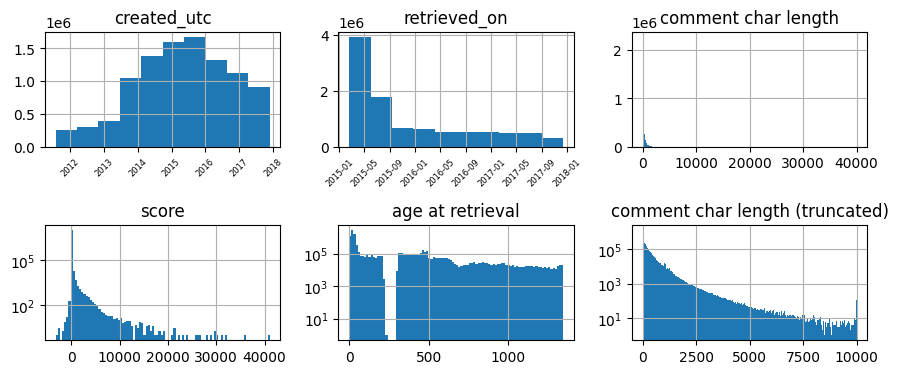

In [11]:
figsize=(9, 4)

fig, axes = plt.subplots(nrows=2, ncols=3)

axes[0, 0].set_title('created_utc')
df_elif_comments.created_utc.hist(ax=axes[0, 0], xrot=45, figsize=figsize, xlabelsize=6)

axes[0, 1].set_title('retrieved_on')
df_elif_comments.retrieved_on.hist(ax=axes[0, 1], xrot=45, figsize=figsize, xlabelsize=6)

axes[0, 2].set_title('comment char length')
df_elif_comments.body.apply(len).hist(ax=axes[0, 2], bins=1000, figsize=figsize)

axes[1, 0].set_title('score')
df_elif_comments.score.hist(ax=axes[1, 0], bins=100, log=True, figsize=figsize)

axes[1, 1].set_title('age at retrieval')
(df_elif_comments['retrieved_on'] - df_elif_comments['created_utc']).dropna().apply(lambda x: x.days).hist(ax=axes[1, 1], bins=100, log=True, figsize=figsize)

axes[1, 2].set_title('comment char length (truncated)')
df_elif_comments.body.apply(lambda t: min(10000, len(t))).hist(ax=axes[1, 2], bins=1000, log=True, figsize=figsize)

fig.tight_layout()

In [12]:
# Let's create a dataset that shows the top-level comments per submission

# We ignore the deleted comments 
df = df_elif_comments.query('deleted == False')

# We keep only top-level comments
df = df.query('parent_id == link_id')
df['link_id'] = df['link_id'].apply(lambda x: x[3:])
del df['parent_id']

# Let's bring in the submission bodies and titles 
df = df.join(df_elif_submissions[['id', 'title', 'selftext', 'deleted']].set_index('id').add_prefix('submission_'), on='link_id')

# We remove submissions that are deleted 
df = df.query('submission_deleted == False')
del df['submission_deleted']

# Now, let's sort by score within each submission
df = df.sort_values(['link_id', 'score'], ascending=[True, False])

# Now, we index by parent id and id to get the comments per post 
df = df.set_index(['link_id', 'id'])

# We keep only submissions with more than 1 comment
df = df.reset_index().groupby('link_id').filter(lambda x: len(x) > 1).set_index(['link_id', 'id'])

<Axes: >

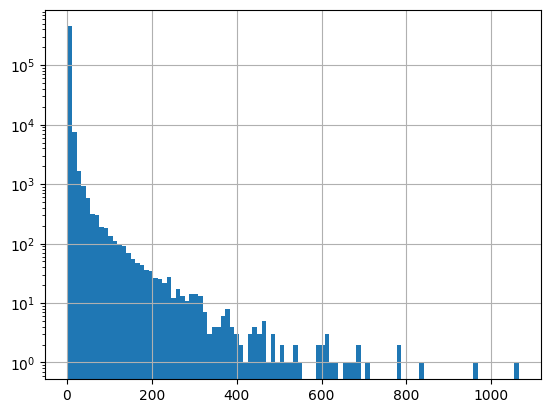

In [13]:
# Now, let's understand how many comments per submission we have
df.reset_index().groupby('link_id').count()['id'].hist(log=True, bins=100)

In [14]:
# Finally, let's assemble our dataset for training 

# Per submission, we create a list of comments that are dicts
def group_to_dicts(group): 
    return group.to_dict(orient='records')

df_final_comments = df.reset_index().groupby('link_id').apply(group_to_dicts)
df_final_comments = pd.DataFrame({'comments': df_final_comments})

df_final = df.reset_index()[['link_id', 'submission_title', 'submission_selftext']].drop_duplicates()
df_final = df_final.set_index('link_id').join(df_final_comments, how='inner').reset_index()

# As a sanity check, let's make sure every submission has comments
print(f'No submissions without comments: {df_final[df_final.comments.apply(len) == 0].shape[0] == 0}')

# Shuffle dataset
df_final = df_final.sample(frac=1)

No submissions without comments: True


In [30]:
df_final.to_json('/scratch1/jhoff/elif_full.jsonl', orient='records', lines=True)

In [15]:
df_final.head(10)

,link_id,submission_title,submission_selftext,comments
87714,1vk3xw,ELI5: Why was it that the whole of Europe (and...,I am British but I am curious to as why the wh...,"[{'link_id': '1vk3xw', 'id': 'cet1dl7', 'creat..."
276235,38eme9,ELI5: why do I see screen tearing on PC games ...,I've always assumed it's because consoles were...,"[{'link_id': '38eme9', 'id': 'crufqgo', 'creat..."
313300,3jsuiw,ELI5: How is it possible for a black hole to e...,,"[{'link_id': '3jsuiw', 'id': 'curza95', 'creat..."
140183,289obc,ELI5: what's the difference between quick nap ...,,"[{'link_id': '289obc', 'id': 'ci8tdhy', 'creat..."
282632,3agtii,ELI5:Why does anyone use condoms to prevent pr...,,"[{'link_id': '3agtii', 'id': 'cschz1y', 'creat..."
332644,3szwff,ELI5:Why do all animals generally have their g...,"Dogs, cats, ducks, bunnies, etc","[{'link_id': '3szwff', 'id': 'cx1wgat', 'creat..."
45899,1lys5d,ELI5: Why are cars so expensive?,"Well, they have a lot of electronics and mecha...","[{'link_id': '1lys5d', 'id': 'cc478yv', 'creat..."
398016,5qe5pd,ELI5: Why do kernels of microwave popcorn pop ...,,"[{'link_id': '5qe5pd', 'id': 'dcyi9kk', 'creat..."
201147,2nv8hy,"ELI5: I'm 17 and have never had a nose bleed, ...",,"[{'link_id': '2nv8hy', 'id': 'cmh6e4q', 'creat..."
379269,50aine,ELI5: What is an Ion?,I searched and I couldn't find an explanation ...,"[{'link_id': '50aine', 'id': 'd731032', 'creat..."


{'link_id': '5nq8an',
 'submission_title': 'ELI5: Why does water not always act as a lubricant?',
 'submission_selftext': '',
 'response_j': "Water [has both *cohesion* -- wants to stick to itself -- and *adhesion* -- wants to stick to other things](https://water.usgs.gov/edu/adhesion.html). So, water is a fluid, and wants to stick to itself as a single object, which makes it somewhat slippery.\n\nBut, it also wants to stick to you, and anything else it touches, on a small scale,  It's how drops stick to the wall in the shower, and you can press something light and smooth against something else smooth with just a little water in between and it will stick.\n\nSo, on a large scale your tires can slip on a wet road because the water is forming a barrier between the tire and the road through cohesion, but on a small scale like rubbing skin together, the water is trying to stick and causes friction.",
 'response_k': 'Water "always" acts as a "lubricant", but it\'s not a very _good_ lubrican

In [ ]:
#def read_jsonl(fname, max_rows=None):
#    rows = []
#    with jsonlines.open(fname) as reader:
#        for obj in reader:
#            rows.append(obj)
#
#            if max_rows is not None and len(rows) >= max_rows:
#                break
#
#    return rows

#elif_comments = read_jsonl(ELIF_COMMENTS, max_rows=1e5)
#elif_submissions = read_jsonl(ELIF_SUBMISSIONS, max_rows=1e5)

#get_keys = lambda x: sorted(list({k for r in x for k in r.keys()}))
#print(f'Keys in submissions: {get_keys(elif_submissions)}')
#print(f'Keys in comments: {get_keys(elif_comments)}' )

#Keys in submissions: ['approved_by', 'author', 'author_flair_css_class', 'author_flair_text', 'banned_by', 'clicked', 'created', 'created_utc', 'distinguished', 'domain', 'downs', 'edited', 'gilded', 'hidden', 'id', 'is_self', 'likes', 'link_flair_css_class', 'link_flair_text', 'media', 'media_embed', 'mod_reports', 'name', 'num_comments', 'num_reports', 'over_18', 'permalink', 'report_reasons', 'retrieved_on', 'saved', 'score', 'secure_media', 'secure_media_embed', 'selftext', 'selftext_html', 'stickied', 'subreddit', 'subreddit_id', 'thumbnail', 'title', 'ups', 'url', 'user_reports']
#Keys in comments: ['archived', 'author', 'author_flair_css_class', 'author_flair_text', 'body', 'controversiality', 'created_utc', 'distinguished', 'downs', 'edited', 'gilded', 'id', 'link_id', 'name', 'parent_id', 'retrieved_on', 'score', 'score_hidden', 'subreddit', 'subreddit_id', 'ups']

# def get_submission(parent_id): 
#
#     if not parent_id.startswith('t3_'):
#         return
#    
#     submission_id = parent_id.replace('t3_', '')
#
#     result = filter(lambda row: row['id'] == submission_id, elif_submissions)
#     result = next(result, None)
#
#     return result
# 
# i = 4
#print(elif_comments[i]['body'])
#get_submission(elif_comments[i]['parent_id'])